In [68]:
import numpy as np
import xarray as xr
import dask.array as da
from dask.distributed import Client, LocalCluster
import gc
import sys
from matplotlib import pyplot as plt

In [69]:
EARTH_RADIUS_KM = 6371.0
MAX_DIST_KM = 500
TIME_TOL_HOURS = 8
ALT_MIN, ALT_MAX = 5.5, 93.5
ALT_GRID = np.arange(ALT_MIN, ALT_MAX + 1, dtype=np.float32)
TIME_TOL = np.timedelta64(TIME_TOL_HOURS, 'h').astype('timedelta64[ns]')

CHUNK_SIZE_L = 100000
CHUNK_SIZE_S = 50000

In [70]:
def process_dataarray(da_o3):
    if not "DATETIME" in da_o3.coords:
        time_chunks = CHUNK_SIZE_L if da_o3.size > 500000 else CHUNK_SIZE_S
        
        if isinstance(da_o3.data, da.Array):
            da_o3 = da_o3.chunk({'time': time_chunks})
        else:
            da_o3.data = da.from_array(da_o3.data, 
                                            chunks= time_chunks)
    
    else:
        time_chunks = CHUNK_SIZE_L if da_o3.size > 500000 else CHUNK_SIZE_S
        
        if isinstance(da_o3.data, da.Array):
            da_o3 = da_o3.chunk({'DATETIME': time_chunks})
        else:
            da_o3.data = da.from_array(da_o3.data, 
                                            chunks= time_chunks)
    return da_o3

def compute_diffs(o3L, o3S):
    """Vectorized relative, absolute and raw difference computation"""
    sum_vals = o3L + o3S
    diff_vals = o3L - o3S
    return 200 * (diff_vals / sum_vals), np.abs(diff_vals), diff_vals

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance calculation between points (in radians)"""
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS_KM * c

In [71]:
import ACEFTS.ACEFTS_helper as ACE
import PEARL_FTIR.PEARL_FTIR_helper as PEARL

In [72]:
daA = ACE.get_column_DU(ALT_MIN, ALT_MAX)
daP = PEARL.get_column_DU(ALT_MIN, ALT_MAX)

In [73]:
daA = process_dataarray(daA)
daP = process_dataarray(daP)

In [74]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit='3GB',
    processes=False,
    dashboard_address=None
)
client = Client(cluster)


In [75]:
o3A_arr = daA.values.astype(np.float32)
latA = daA.latitude.values
lonA = daA.longitude.values
tA = daA.time.values.astype('datetime64[ns]')

o3P_arr = daP.values.astype(np.float32)
tP = daP.DATETIME.values.astype('datetime64[ns]')
num_P_data = len(tP)
latP = np.array([PEARL.latitude] * num_P_data)
lonP = np.array([PEARL.longitude] * num_P_data)

tP_min = tP.min() - TIME_TOL
tP_max = tP.max() + TIME_TOL
first_time_mask = (tA >= tP_min) & (tA <= tP_max)
tA_filtered = tA[first_time_mask]
o3A_arr_filtered = o3A_arr[first_time_mask]
latA_filtered = latA[first_time_mask]
lonA_filtered = lonA[first_time_mask]

client.close()
cluster.close()
del o3A_arr, latA, lonA
gc.collect() 

12585

In [76]:
tA_ns = tA_filtered.astype(np.int64)
tP_ns = tP.astype(np.int64)
TIME_TOL_ns = TIME_TOL.astype(np.int64)

MAX_DIST_RAD = MAX_DIST_KM / EARTH_RADIUS_KM

processed_pairs = 0
o3P_coincidences = []
o3A_coincidences = []
o3P_coincidences_idx = []
o3A_coincidences_idx = []
days_of_year = []

time_bins = np.arange(tA_ns.min(), tA_ns.max() + 1, TIME_TOL_ns)
bin_indices = np.digitize(tA_ns, time_bins)

max_bin = len(time_bins) + 1
time_binned_arrays = [np.array([], dtype=np.int64) for _ in range(max_bin + 1)]

for bin_id in range(0, max_bin + 1):
    time_binned_arrays[bin_id] = np.where(bin_indices == bin_id)[0]

bin_offsets = np.arange(-1, 2)

for s_idx, (s_time, s_lat, s_lon) in enumerate(zip(tP_ns, latP, lonP)):
    if s_idx % 10000 == 0:
        print(f"Processing PEARL FTIR point {s_idx}/{len(tP)}...")
    
    center_bin = np.digitize(s_time, time_bins)
    bin_ids = center_bin + bin_offsets
    bin_ids = bin_ids[(bin_ids >= 1) & (bin_ids < max_bin)]

    candidate_indices = np.concatenate([time_binned_arrays[bin_id] for bin_id in bin_ids])
    if candidate_indices.size == 0:
        continue

    time_diffs = np.abs(tA_ns[candidate_indices] - s_time)
    time_mask = time_diffs <= TIME_TOL_ns

    if not np.any(time_mask):
        continue

    time_valid_indices = candidate_indices[time_mask]
    candidate_lats = latA_filtered[time_valid_indices]
    candidate_lons = lonA_filtered[time_valid_indices]
    
    dists = haversine_vectorized(s_lat, s_lon, candidate_lats, candidate_lons)
    min_idx = np.argmin(dists)
    min_dist = dists[min_idx]

    if min_dist <= MAX_DIST_KM:
        best_L_idx = time_valid_indices[min_idx]
        o3A_coincidences.append(o3A_arr_filtered[best_L_idx])
        o3P_coincidences.append(o3P_arr[s_idx])
        processed_pairs += 1

        o3A_coincidences_idx.append(best_L_idx)
        o3P_coincidences_idx.append(s_idx)

        dt = tA_ns[best_L_idx]
        dt = dt.astype('datetime64[ns]')
        day_of_year = ((dt - dt.astype('datetime64[Y]'))   // np.timedelta64(1, 'D')) + 1

        days_of_year.append(day_of_year)
        if processed_pairs % 1000 == 0:
            print(f"Found {processed_pairs} pairs at PEARL FTIR point {s_idx}...")

o3P_coincidences = np.vstack(o3P_coincidences)
o3A_coincidences = np.vstack(o3A_coincidences)
print(f"Total coincidences found: {processed_pairs}")

Processing PEARL FTIR point 0/6261...
Found 1000 pairs at PEARL FTIR point 4183...
Total coincidences found: 1359


In [77]:
# o3S_coincidences[o3S_coincidences == 0] = np.nan
# o3L_coincidences[o3L_coincidences == 0] = np.nan
o3A_coincidences[o3A_coincidences == np.float32("inf")] = np.nan
o3P_coincidences[o3P_coincidences == np.float32("inf")] = np.nan

In [78]:
rel, abs, raw = compute_diffs(o3A_coincidences, o3P_coincidences)

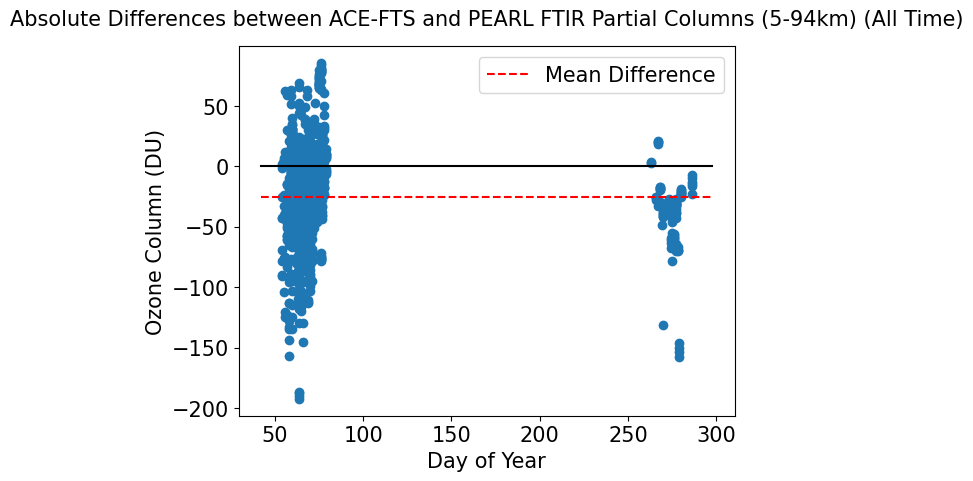

In [79]:
plt.scatter(days_of_year, raw)
raw_mean = np.nanmean(raw)
xlims = list(plt.xlim())
plt.plot(xlims, [0, 0], color = "black")
plt.plot(xlims, [raw_mean, raw_mean], color = "red", linestyle = "dashed", label = "Mean Difference")
plt.xlabel("Day of Year")
plt.ylabel("Ozone Column (DU)")

plt.title("Absolute Differences between ACE-FTS and PEARL FTIR Partial Columns" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (All Time)", fontdict = {'fontsize': 15}, pad=15)

plt.legend()
fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

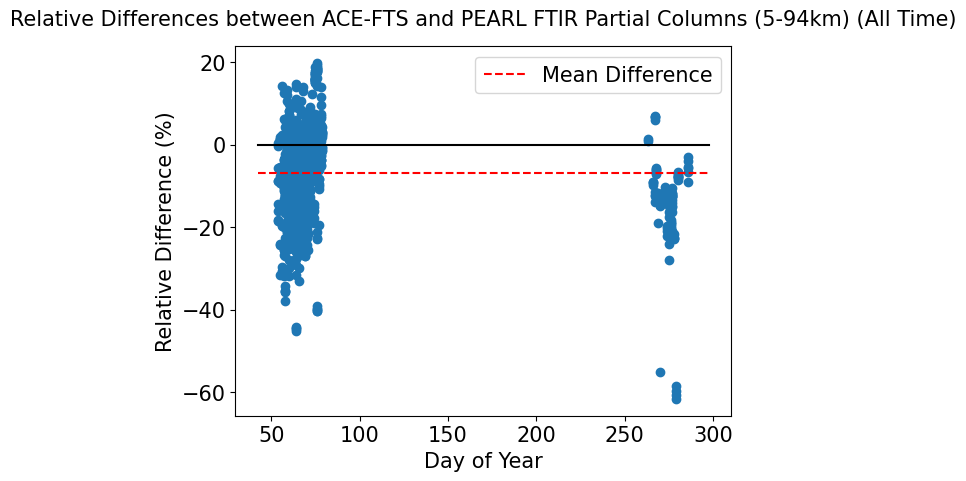

In [80]:
plt.scatter(days_of_year, rel)
rel_mean = np.nanmean(rel)
xlims = list(plt.xlim())
plt.plot(xlims, [0, 0], color = "black")
plt.plot(xlims, [rel_mean, rel_mean], color = "red", linestyle = "dashed", label = "Mean Difference")
plt.xlabel("Day of Year")
plt.ylabel("Relative Difference (%)")

plt.title("Relative Differences between ACE-FTS and PEARL FTIR Partial Columns" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (All Time)", fontdict = {'fontsize': 15}, pad=15)

plt.legend()
fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

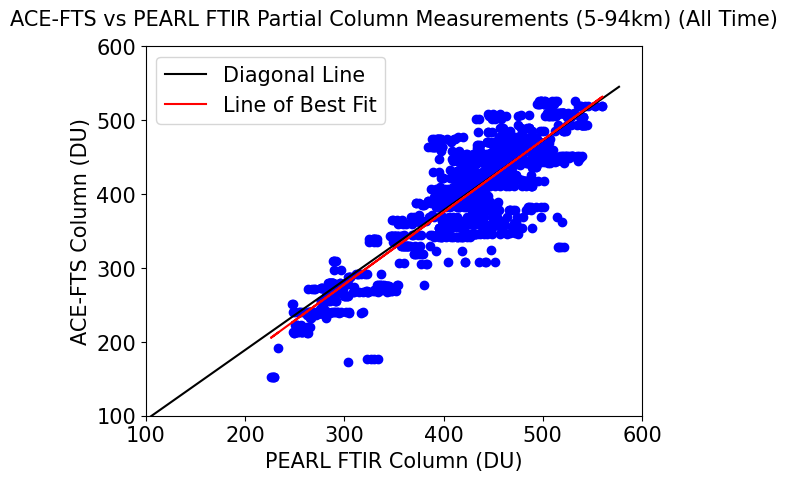

In [81]:
plt.scatter(o3P_coincidences, o3A_coincidences, color = "blue")
plt.xlabel("PEARL FTIR Column (DU)")
plt.ylabel("ACE-FTS Column (DU)")

plt.title("ACE-FTS vs PEARL FTIR Partial Column Measurements" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (All Time)", fontdict = {'fontsize': 15}, pad=15)
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot([0, xlims[1]], [0, ylims[1]], color = "black", label = "Diagonal Line")

mask = np.isfinite(o3A_coincidences) & np.isfinite(o3P_coincidences)
o3L_coincidences_nonan = o3A_coincidences[mask]
o3S_coincidences_nonan = o3P_coincidences[mask]

slope, intercept = np.polyfit(o3S_coincidences_nonan, o3L_coincidences_nonan, 1)
line = slope * o3P_coincidences + intercept
plt.plot(o3P_coincidences, line, color = "red", label = "Line of Best Fit")
plt.xlim(100, 600)
plt.ylim(100, 600)

plt.legend()

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [82]:
o3A_std = np.nanstd(o3A_coincidences)
o3P_std = np.nanstd(o3P_coincidences)
o3A_mean = np.nanmean(o3A_coincidences)
o3P_mean = np.nanmean(o3P_coincidences)

In [83]:
L_minus_mean = (o3A_coincidences - o3A_mean)
S_minus_mean = (o3P_coincidences - o3P_mean)

In [84]:
o3P_mean

np.float32(414.5732)

In [85]:
summing = np.nansum((L_minus_mean / o3A_std) * (S_minus_mean / o3P_std)) / (len(L_minus_mean) - 1)
summing

np.float32(0.8885813)